In [122]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/home/ubuntu/varios/skforecast')

In [123]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals
from skforecast.utils import multivariate_time_series_corr
from skforecast.plot import plot_multivariate_time_series_corr

# Plot Residuals

In [124]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [125]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = False
                               )

In [126]:
residuals = predictions_backtest['pred'] - data_test['y']

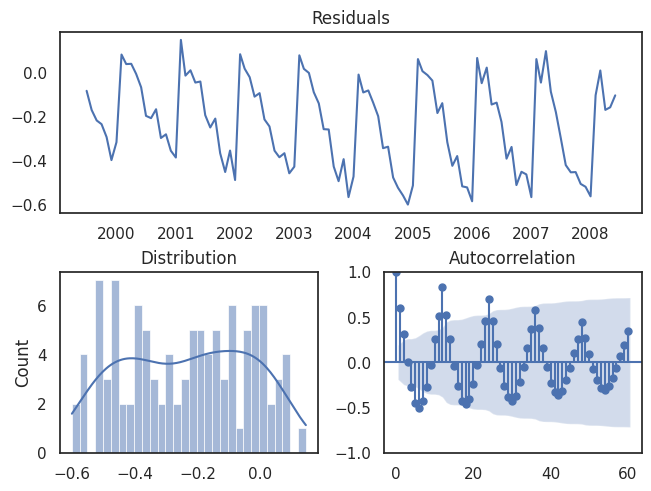

In [127]:
plot_residuals(residuals=residuals)

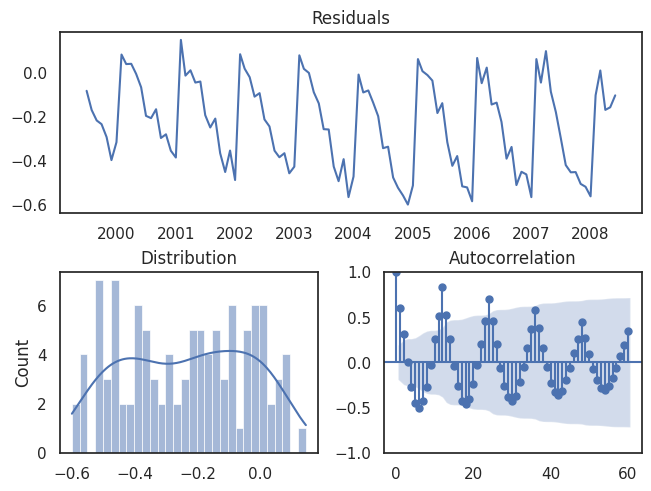

In [128]:
plot_residuals(y_true=data_test['y'], y_pred=predictions_backtest['pred'])

# multivariate_time_series_corr 

In [129]:
# Data download
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/air_quality_valencia.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.drop(columns=['veloc.', 'direc.'])
data = data.asfreq('H')
data = data.sort_index()
data = data.loc['2021-01-01 00:00:00': '2021-12-31 11:00:00']

# Aggregating in 1D intervals
# ==============================================================================
data = data.resample(rule='D', closed='left', label ='left').mean()
data.head()

# Missing imputation with rolling mean
# ==============================================================================
data['pm2.5'] = data['pm2.5'].fillna(data['pm2.5'].rolling(window='25d', center=True, axis=0).mean())
data['pm10']  = data['pm10'].fillna(data['pm10'].rolling(window='25d', center=True, axis=0).mean())
data['co']    = data['co'].fillna(data['co'].rolling(window='10d', center=True, axis=0).mean())
data['o3']    = data['o3'].fillna(data['o3'].rolling(window='5d', center=True, axis=0).mean())
data['so2']   = data['so2'].fillna(data['so2'].rolling(window='10d', center=True, axis=0).mean())

data= pd.concat([data,data,data,data,data])

In [130]:
corr = multivariate_time_series_corr(
    time_series = data['pm2.5'],
    other       = data,
    lags        = 5
)
corr

,pm2.5,co,no,no2,pm10,nox,o3,so2
lag,,,,,,,,
0,1.000000,-0.050437,0.358713,0.427705,0.835836,0.435800,-0.260211,-0.123025
1,0.774216,-0.099094,0.228872,0.386544,0.696288,0.350768,-0.203467,-0.131022
2,0.541201,-0.076636,0.171215,0.283146,0.548634,0.259532,-0.181258,-0.126705
3,0.385159,-0.049723,0.063409,0.121179,0.429336,0.108291,-0.105378,-0.123055
4,0.305035,-0.036743,0.009427,0.012708,0.357420,0.014990,-0.043324,-0.121805


<AxesSubplot: xlabel='Time series', ylabel='lag'>

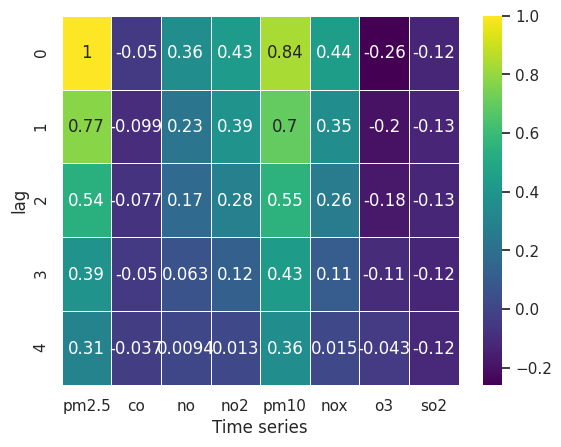

In [131]:
plot_multivariate_time_series_corr(corr)

# Ridge Plot

In [132]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [133]:
forecaster.fit(y=data.y)
pred = forecaster.predict_bootstrapping(steps=10, n_boot=50)
pred

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_40,pred_boot_41,pred_boot_42,pred_boot_43,pred_boot_44,pred_boot_45,pred_boot_46,pred_boot_47,pred_boot_48,pred_boot_49
2008-07-01,0.728822,0.737767,0.803769,0.735674,0.806414,0.833497,0.703955,0.957734,0.743416,0.828267,...,1.009476,0.906546,0.957692,0.801852,0.761306,0.743416,0.949781,0.910387,0.655424,0.957734
2008-08-01,0.922899,0.947186,0.789037,0.879750,0.906976,0.808887,0.753895,0.998746,0.675858,0.831930,...,1.119721,0.459595,0.858318,0.861238,0.827399,0.714668,0.544581,1.035098,0.689831,0.998746
2008-09-01,0.937284,0.482471,1.010562,0.792776,0.771851,0.402672,0.776309,1.100611,0.772435,0.846785,...,0.998458,0.826659,0.964882,0.714470,0.803786,0.935153,0.628829,1.107278,0.630195,1.100611
2008-10-01,0.498857,0.717546,0.880583,0.961407,0.433091,0.535335,0.297042,0.908873,0.940165,0.883530,...,1.028444,0.952207,0.569439,0.942406,0.468058,0.817197,0.332058,0.608232,0.640729,0.908873
2008-11-01,0.709817,0.884795,0.896081,0.909852,0.587060,0.491967,0.478518,0.918423,0.860444,0.871596,...,1.000088,1.011614,0.618514,0.857875,0.764467,0.880643,0.648201,0.616664,0.721436,0.918423
2008-12-01,0.702532,0.866965,1.114858,0.392987,0.605321,0.543205,0.746334,0.891469,1.022358,0.548760,...,1.140326,0.975620,0.610567,0.873591,0.715630,0.558815,0.588765,0.666752,0.311514,0.891469
2009-01-01,0.761898,1.054947,1.040711,0.541405,0.569716,0.511075,0.786835,0.792110,0.973473,0.212429,...,1.013889,1.095540,0.777137,0.806818,0.652475,0.627668,0.658337,0.635395,0.419203,0.792110
2009-02-01,0.829405,0.934312,1.098026,0.512531,0.560150,0.622232,0.773743,0.811242,0.889361,0.401381,...,0.985758,1.180347,0.698564,0.708148,0.828852,0.576114,0.757669,0.834584,0.591396,0.811242
2009-03-01,0.776323,0.889353,0.953689,0.658422,0.700230,0.886339,0.864425,1.013616,0.563587,0.564013,...,1.008226,0.949368,0.356904,0.984085,0.835614,0.618287,0.698724,0.927207,0.566428,1.013616
2009-04-01,1.016998,0.839095,1.047093,0.698132,0.708085,1.015096,0.797039,1.080803,0.873155,0.725513,...,1.084500,1.072480,0.461849,0.765969,0.924585,0.776335,0.764786,1.088972,0.829260,1.080803


In [159]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import seaborn as sns

IndexError: list index out of range

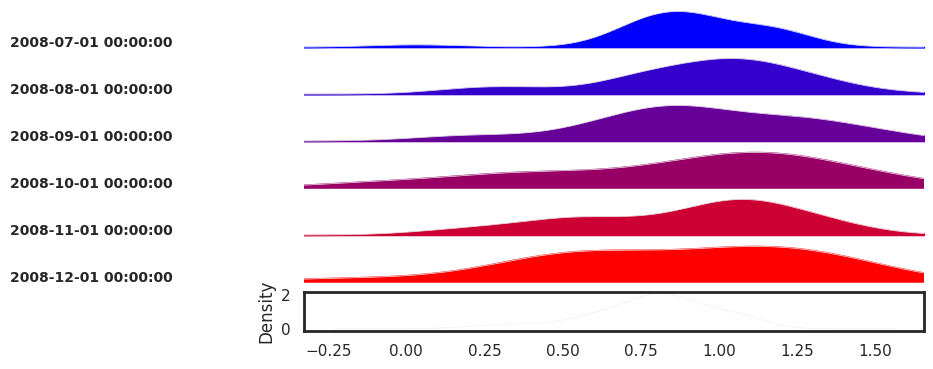

In [160]:
gs = (grid_spec.GridSpec(len(pred), 1))
fig = plt.figure(figsize=(8,6))
ax_objs = []

colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

for i, step in enumerate(pred.index):
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    
    plot = (pred.loc[step].plot.kde(ax=ax_objs[-1], color="#f0f0f0", lw=0.5))

    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y

    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x, y, color=colors[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(pred.values.min(), pred.values.max())
    # ax_objs[-1].set_ylim(0,2.2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    if i == len(pred)-1:
        pass
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.02, 0, str(step) , fontweight="bold", fontsize=10, ha="right")

gs.update(hspace=-0.1)

fig.text(0.07,0.85,"Distribution predictions",fontsize=20)

plt.tight_layout()
plt.show()

/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout(*args, **kwargs)
/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout(*args, **kwargs)
/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout(*args, **kwargs)


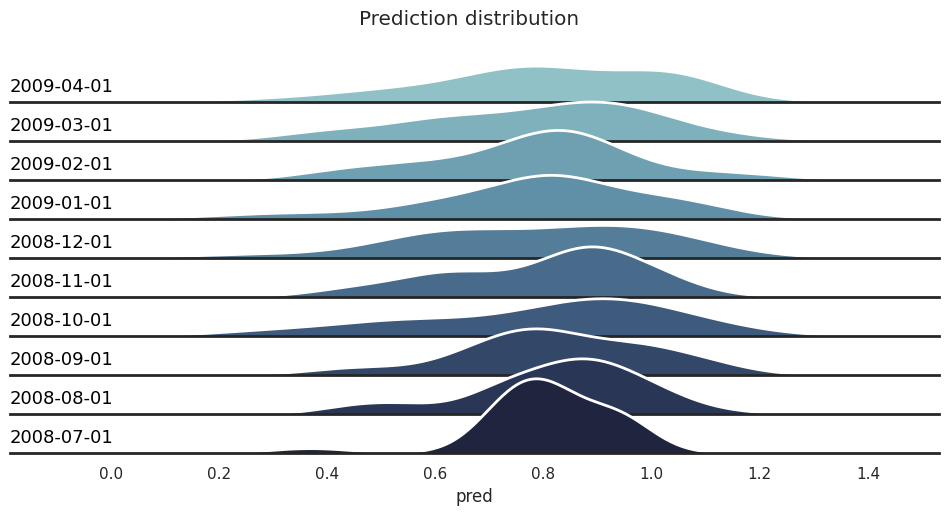

In [167]:
def plot_prediction_distributions(bootstrapping_predictions):
    """
    

    Parameters
    ----------
    bootstrapping_predictions : _type_
        _description_
    """

    df = bootstrapping_predictions.stack().droplevel(level=1, axis=0).to_frame(name='pred')
    df.index.name='step'
    df = df.reset_index()
    df['step'] = df['step'].astype(str)
    df

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.cubehelix_palette(10, rot=-.25, light=.7, reverse=True)
    row_order = list(df.step.unique())
    row_order.reverse()
    g = sns.FacetGrid(df, palette=palette, row="step", hue="step", aspect=20, height=0.5, row_order=row_order)
    g.map_dataframe(sns.kdeplot, x="pred", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="pred", color='w', lw=2)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "step")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="pred")
    g.despine( left=True)
    plt.suptitle('Prediction distribution', y=0.98)


plot_prediction_distributions(pred)